In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.stats
#import seaborn as sns
#sns.set(style="whitegrid")
import time
import seaborn as sns; sns.set()
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy
import random

In [89]:
def Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn):
    scale_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        scale_ext[r,:eff_date] = sigma_adjust1[r]*np.ones(int(eff_date))
        scale_ext[r,eff_date:] = d*sigma_adjust2[r]*np.ones(int(nn - eff_date))
    return scale_ext

In [90]:
def C_series(eff_dates,pr1,pr2,nn):
    C_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        C_ext[r,:eff_date] = pr1*np.ones(int(eff_date))
        C_ext[r,eff_date:] = pr2*np.ones(int(nn - eff_date))
    return C_ext

In [91]:
def SEIR_Policy_relax(init_vals, C_, Sigma_, p,f, params, d, eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn):
    ## input
    # nn is the number of days
    #S_0,E_0,I_0,R_0: dimension: A*R
    # C is a matrix in dimension R*R with compotnent c_(r,r')
    # p is vector in dimension A with each column equals to p_a
    S_0, E_0, I_0, A_0, D_0,R_0 = init_vals
    
    N_A, N_K = S_0.shape[0], S_0.shape[1]
      
    S, E, I, A, D, R = [S_0], [E_0], [I_0], [A_0], [D_0],[R_0]
    
    R_I = [R_0]
    R_A = [R_0]
    
    # N: total number of people in each class: matrix dimension A*R
    N = S_0 + E_0 + I_0 + R_0 +D_0+ A_0
    S_i, E_i, I_i, A_i, D_i, R_i = S_0.copy(), E_0.copy(), I_0.copy(), A_0.copy(), D_0.copy(),R_0.copy()
    
    R_i_I,R_i_A = R_0.copy(),R_0.copy()
    
    alpha, beta, gamma, kappa,pi  = params
    Sigma = Sigma_
    C = C_
    
    ### time-dependent parameters
    scale_ts = Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn)
    C_ts = C_series(eff_dates,1.0,0.2,nn)
    
    
    regional_real_cases = np.zeros((nn+1,N_A,N_K))
    regional_confirm_cases = np.zeros((nn+1,N_A,N_K))
    england_real_cases = np.zeros((nn+1,N_A))
    england_confirm_cases = np.zeros((nn+1,N_A))
    
    regional_real_cases[0,:,] = I_0
    england_real_cases[0] = np.sum(I_0)
    for region in range(N_K):
            for age in range(N_A):
                number = I_0[age,region]
                regional_confirm_cases[0,age,region] =  np.random.binomial(number, pi, 1)[0] 
    england_confirm_cases[0,:] = np.sum(regional_confirm_cases[0,:,:],axis=1)
    total_contact = 0
    # signal==0 means relax policy (not control)
    # signal > 0 means control 
    signals = np.zeros(nn)
    signals[:relax_day] = 1
    
    mask_base = np.arange(16)
    mask = (mask_base < 4) | (mask_base > 11)
    for t in range(nn):
        day_contact = 0
        signal = signals[t]
        Lambda = np.zeros((N_A,N_K))
        if signal > 0:
            #for r in range(N_K):
            C_r = C_ts[:,t]*C_ + (1-C_ts[:,t])*np.identity(133)
            Lambda += np.dot(Sigma[:,mask], np.reshape(scale_ts[:,t], (1, -1)) * alpha *(kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:])
            Lambda += np.dot(Sigma[:,~mask], np.reshape(scale_ts[:,t], (1, -1)) * alpha * np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T))
            day_contact += (N * np.dot(np.reshape(np.sum(Sigma, axis=-1), (-1, 1)), np.reshape(scale_ts[:,t], (1, -1)))).flatten().sum()
            
                
                #for a in range(N_A):
                #    for a_prime in [0,1,2,3,12,13,14,15]:
                #        Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
                #    for a_prime in [4,5,6,7,8,9,10,11]:
                #        Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
                #    day_contact += N[a,r] *scale_ts[r,t] *np.sum(Sigma[a,:])
        if signal ==0 :
            #for r in range(N_K):
            C_ts_tmp = relax
            C_r = C_ts_tmp*C_ + (1-C_ts_tmp)*np.identity(N_K)
            scale_ts_tmp = relax*sigma_adjust1 + (1-relax)*scale_ts[:,t] 
            Lambda += (alpha * np.dot(Sigma[:, mask], (kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:] * scale_ts_tmp.reshape((1, -1))))
            Lambda += (alpha * np.dot(Sigma[:,~mask], np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T) * scale_ts_tmp.reshape((1, -1))))
            day_contact  += (N * np.dot(Sigma.sum(axis=-1).reshape((-1, 1)), scale_ts_tmp.reshape((1, -1)))).flatten().sum()
            
                #C_ts_tmp = relax #np.min([1,relax*C_ts[r,t]])
                #C_r = C_ts_tmp*C_ + (1-C_ts_tmp)*np.identity(133)
                #scale_ts_tmp = relax*sigma_adjust1[r] + (1-relax)*scale_ts[r,t] 
                #for a in range(N_A):
                #    for a_prime in [0,1,2,3,12,13,14,15]:
                #        Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
                #    
                #    for a_prime in [4,5,6,7,8,9,10,11]:
                #        Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
                #    day_contact +=  N[a,r] *scale_ts_tmp*np.sum(Sigma[a,:])
                
                
        total_contact += day_contact      
        dI_i = np.zeros((N_A,N_K))
        dA_i = np.zeros((N_A,N_K))
        for a in range(N_A):
            dI_i[a,:] += p[a]*beta*E_i[a,:]
            dA_i[a,:] += (1-p[a])*beta*E_i[a,:]
        
        compartment_prob = np.array([(S_i*Lambda), dI_i, dA_i ,(gamma*f*I_i),(gamma*(1-f)*I_i),(gamma*A_i)]).reshape(6*N_A*N_K)

        compartment_prob = np.asarray(compartment_prob).astype(np.float64)
        ratio = np.sum(compartment_prob)
        if ratio > 0:
            compartment_prob /= np.sum(compartment_prob)
        else:
            total_contact += (nn-t)*day_contact 
            return S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact

        number_event = np.random.poisson(ratio,1)[0]
    
        ind = np.random.multinomial(number_event, compartment_prob, size=1)
        
        ind = ind.reshape(6,N_A,N_K)

        

        S_i += -ind[0,:,:]
        E_i += ind[0,:,:]-ind[1,:,:]-ind[2,:,:]
        I_i += ind[1,:,:]-ind[3,:,:]-ind[4,:,:]
        A_i += ind[2,:,:]-ind[5,:,:]
        D_i += ind[3,:,:]
        R_i += ind[4,:,:]+ind[5,:,:]
        
        R_i_A += ind[5,:,:]
        R_i_I += ind[4,:,:]
        
        S_i = (np.abs(S_i)+S_i)/2
        E_i = (np.abs(E_i)+E_i)/2
        A_i = (np.abs(A_i)+A_i)/2
        D_i = (np.abs(D_i)+D_i)/2
        I_i = (np.abs(I_i)+I_i)/2
        R_i = (np.abs(R_i)+R_i)/2
        
        R_i_I = (np.abs(R_i_I)+R_i_I)/2
        R_i_A = (np.abs(R_i_A)+R_i_A)/2
        
        
        regional_real_cases[t+1,:,:] = ind[1,:,:]
        england_real_cases[t+1,:] = np.sum(ind[1,:,:],axis=1)
        for region in range(N_K):
            for age in range(N_A):
                number = ind[1,age,region]
                regional_confirm_cases[t+1,age,region] =  np.random.binomial(number, pi, 1)[0] 
        
        today_confirm = np.sum(regional_confirm_cases[t+1,:,:],axis=1)
        england_confirm_cases[t+1,:] = today_confirm
        
        
        S.append(S_i.copy())
        E.append(E_i.copy())
        I.append(I_i.copy())
        A.append(A_i.copy())
        D.append(D_i.copy())
        R.append(R_i.copy())
        
        R_A.append(R_i_A.copy())
        R_I.append(R_i_I.copy())
        
        
        
        
         
    return S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases,total_contact

# Data Preparation

In [92]:
# social contact among age group
contact = pd.read_csv('../../data/contact_matrix_16_groups.csv')
social_m = np.array(contact[['matrix..0.5.', 'matrix..5.10.', 'matrix..10.15.', 'matrix..15.20.',
       'matrix..20.25.', 'matrix..25.30.', 'matrix..30.35.', 'matrix..35.40.',
       'matrix..40.45.', 'matrix..45.50.', 'matrix..50.55.', 'matrix..55.60.',
       'matrix..60.65.', 'matrix..65.70.', 'matrix..70.75.', 'matrix.75.']]).reshape(16,16)

Sigma = social_m

In [93]:
#contact mtrix
transport = pd.read_csv('../../data/CommuteMatrix-NUTS3.csv')
transport_mat = np.array(transport)[:,1:].astype(float)
C = transport_mat

In [94]:
covid_data = pd.read_csv('../../data/UK-COVID-data.csv')
covid_data_new = pd.DataFrame(columns = covid_data.columns)
region_order = list(transport['Unnamed: 0'])

In [95]:
for i in range(133):
    region = region_order[i]
    covid_data_new.loc[i] = covid_data[covid_data['id']==region].values[0]
    #covid_data_new2.loc[i] = covid_data2[covid_data2['id']==region].values[0]

In [96]:
## Sanity check
print('does all tables have the same region order:')
covid_order = list(covid_data_new['id'])
#covid_order2 = list(covid_data_new2['id'])

region_order = list(transport['Unnamed: 0'])

print(region_order ==covid_order)
#print(population_order==covid_order2)

does all tables have the same region order:
True


In [97]:
## Population data validation 
population = pd.read_csv('../../data/UK-COVID-data-with_ALL_age_groups.csv')
population = population[['id', 'Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]

In [98]:
population_new = pd.DataFrame(columns = population.columns)
for i in range(133):
    region = region_order[i]
    population_new.loc[i] = population[population['id']==region].values[0]

In [99]:
N_mat2 = np.array(population_new[['Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]).T

N_mat = np.zeros((16,133))

N_mat[:15,:] = N_mat2[:15,:]

N_mat[-1,:] = np.sum(N_mat2[15:,],axis=0)
np.sum(N_mat)

56171302.0

In [100]:
## Population density
population_density = np.array(covid_data_new['population_density'])

In [101]:
initial_day = 15


In [102]:
N_A= 16
N_K = 133

In [103]:
real_cum_cases = np.sum(np.array(covid_data_new.iloc[0:133,(19+initial_day):103]).astype(float),axis = 0)

In [104]:
real_cum_cases_ind = np.cumsum(np.ones(len(real_cum_cases)))+initial_day

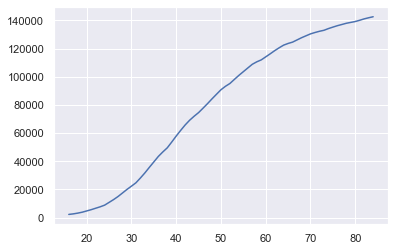

In [105]:
plt.plot(real_cum_cases_ind,real_cum_cases)

In [106]:
d_table =  pd.read_csv('../../data/d1d2_effdates_initialization_final_lowratio_133regions_16agegroups.csv')

initial_covid = np.array(d_table['initialization'])

sigma_adjust1 = np.array(d_table['d_adjust1'])
sigma_adjust2 = np.array(d_table['d_adjust2'])
simulation_eff_dates = np.array(d_table['adjust_dates'])

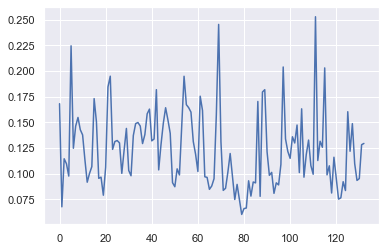

In [107]:
plt.plot(0.12*sigma_adjust2/sigma_adjust1)

In [108]:
death_data = pd.read_csv('../../data/coronavirus-deaths_0615.csv')

cum_death_number = np.array(death_data[death_data['Area name']=='England'][::-1].iloc[9:]['Cumulative deaths'])

cum_death_number_ind = np.cumsum(np.ones(len(cum_death_number)))+initial_day

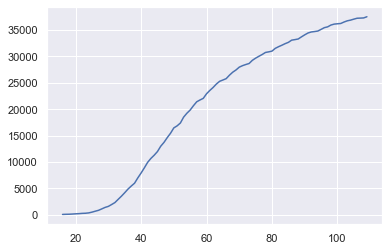

In [109]:
plt.plot(cum_death_number_ind,cum_death_number)

# Initialization

In [110]:
alpha = 0.055 #+ np.random.normal(0, 0.01, 1)[0]
beta = 0.2 #+ np.random.normal(0, 0.05, 1)[0]
gamma = 0.1 #+ np.random.normal(0, 0.02, 1)[0]
kappa = 0.5 # + np.random.normal(0, 0.05, 1)[0]

f0 = 0.002 
f1 = 0.002
f2 = 0.01
f3 = 0.01
f4 = 0.05
f5 = 0.05
f6 = 0.1
f7 = 0.1
f8 =  0.2
f9 = 0.2
f10 = 0.6
f11 = 0.6
f12 = 2.0
f13 = 2.0
f14 = 4.0
f15 = 7.5 


p0 = 0.075 
p1 =  0.075
p2 = 0.05
p3 = 0.05
p4 = 0.15
p5 = 0.15
p6 = 0.21
p7 = 0.21
p8 =  0.23 
p9 = 0.23 
p10 = 0.28
p11 = 0.28
p12 =  0.41
p13 =  0.41
p14 =  0.375
p15 = 0.375
p = [p0,p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15]
pi = 4.5/100
# 0.005,0.25,2,6
f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi

In [111]:
## initial population
init_sick = np.zeros((N_A,N_K))
init_sick_scale = np.zeros((N_A,N_K))
for a in [4,5,6,7,8,9,10,11]:
    init_sick[a,:] = initial_covid*(N_mat[a,:])/np.sum(N_mat[4:12,:],axis=0)

for a in [4,5,6,7,8,9,10,11]:
    init_sick_scale[a,:] = init_sick[a,:]/(p[a]*pi)
#init_sick[1,44] = 5
#init_sick[1,64] = 5
init_vals = N_mat-(init_sick_scale).astype(int),(init_sick_scale).astype(int), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K))

In [112]:
nn=1000
scale=0.12

In [113]:
benchmark_total_contact = 0
for r in range(133):
    for a in range(16):
        benchmark_total_contact += N_mat[a,r]*sigma_adjust1[r]*nn*np.sum(Sigma[a,:])

In [114]:
benchmark_total_contact

613800527142.0557

# Experiments

In [115]:
sns.set(font_scale=1.3)

In [121]:
relax = 0.5
relax_day = 350
nn = 1000

S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,np.ones(133),sigma_adjust2,relax,relax_day,nn)


In [131]:
xx = np.cumsum(np.ones(100))+lag-1

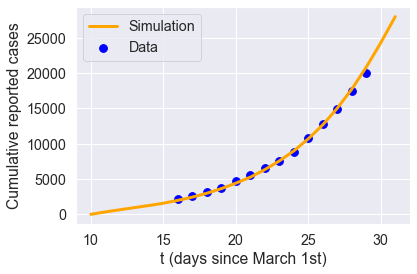

In [151]:
plt.scatter(real_cum_cases_ind[:14],real_cum_cases[:14],label='Data',color='blue',s=60)
plt.plot(xx[:22],np.cumsum(np.sum(england_confirm_cases,axis=1)[:22])*0.73,label='Simulation',linewidth=3,color='orange')
plt.ylabel('Cumulative reported cases')
plt.xlabel('t (days since March 1st)')
plt.legend()
plt.savefig('validation.png',bbox_inches="tight")

# Frontier Visualization

In [38]:
sns.set(font_scale=1.3)

In [39]:
relax_days = [90-15,120-15,150-15,180-15,210-15,270-15,350-15]#[90,120,150,180,210,270,350] - 15
relaxes = list([0.2,0.3,0.4,0.5,0.6,0.8,1.0])

In [41]:
#data = pd.read_csv('../results/frontiers/0712/openloop_differentrelaxation_7-7-30.csv')

In [32]:
data_lowratio = pd.read_csv('../results/frontiers/0721/openloop_differentrelaxation_lowratio_7-7-30.csv')

In [33]:
data.head()

,cost,death
0,5.187947e+11,171524.0
1,5.187947e+11,171541.0
2,5.187947e+11,170612.0
3,5.187947e+11,171409.0
4,5.187947e+11,171189.0


In [34]:
cost = np.array(data['cost']).reshape(7,7,30)
death = np.array(data['death']).reshape(7,7,30)

In [35]:
costs = np.mean(cost,axis=2)
deaths = np.mean(death,axis=2)

In [36]:
cost_lowratio = np.array(data_lowratio['cost']).reshape(7,7,30)
death_lowratio = np.array(data_lowratio['death']).reshape(7,7,30)
costs_lowratio = np.mean(cost_lowratio,axis=2)
deaths_lowratio = np.mean(death_lowratio,axis=2)

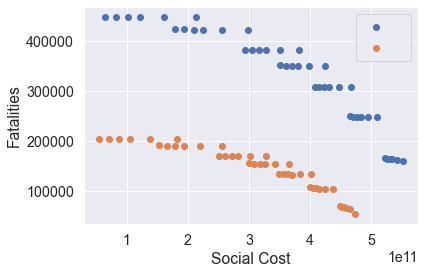

In [165]:
plt.scatter(costs[:,1:],deaths[:,1:],label= ' ')
plt.scatter(costs_lowratio[:,1:],deaths_lowratio[:,1:],label= ' ')
plt.xlabel('Social Cost')
plt.ylabel('Fatalities')
plt.legend()
plt.savefig("../results/frontiers/0721/openloop_diff_lowratio_relaxationlevel.png",bbox_inches="tight")

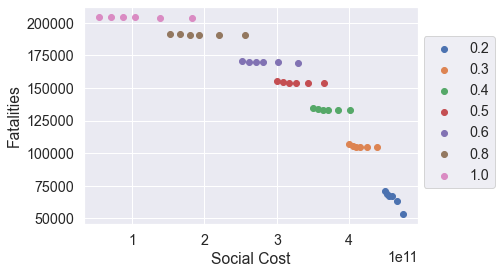

In [166]:
for i in range(7):
    plt.scatter(costs_lowratio[i,1:],deaths_lowratio[i,1:],label=str(relaxes[i]))
plt.legend(bbox_to_anchor=(1.25, 0.9))
plt.xlabel('Social Cost')
plt.ylabel('Fatalities')
plt.savefig("../results/frontiers/0721/openloop_diff_relaxationlevel_levels_lowratio.png",bbox_inches="tight")

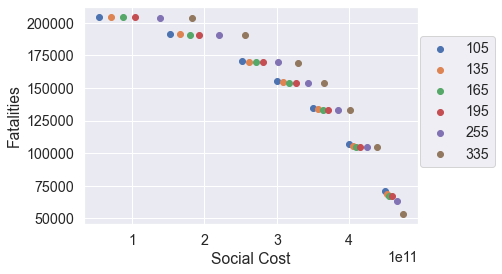

In [167]:
for j in range(1,7):
    plt.scatter(costs_lowratio[:,j],deaths_lowratio[:,j],label=''+str(relax_days[j]))
plt.legend(bbox_to_anchor=(1.25, 0.9))
plt.xlabel('Social Cost')
plt.ylabel('Fatalities')
plt.savefig("../results/frontiers/0721/openloop_diff_relaxationlevel_days_lowratio.png",bbox_inches="tight")

# Improvements along the frontier

In [117]:
death_table = pd.read_csv("../../data/UK-COVID-fatalities-government-fixed.csv")
death_long = np.sum(np.array(death_table.iloc[:,68:308]),axis=0)
death_long = np.sum(np.array(death_table.iloc[:,68:308]),axis=0)
death_short = death_long[1:]-death_long[:-1]

In [ ]:
relax = 0.5
relax_day = 350
nn = 1000

paths = 10

trags = np.zeros((nn+1,paths))
deaths = np.zeros((nn+1,paths))
trags_I = np.zeros((nn+1,paths))
costs = np.zeros(paths)


for path in range(paths):
    print(path)
    S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn)

    lenss = np.array(I).shape[0]
    trags[:,path] = np.sum(england_confirm_cases,axis=1)
    trags_I[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    deaths[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    deaths[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]
    
    end = nn+1
    
    costs[path] = benchmark_total_contact - total_contact
    

In [ ]:
I_mean = np.mean(trags_I,axis=1)
I_std = np.std(trags_I,axis=1)

D_mean = np.mean(deaths,axis=1)
D_std = np.std(deaths,axis=1)

lag = 10

xx = np.cumsum(np.ones(len(D_mean)))-1+lag

In [30]:
relax = 0.25 #0.5
relax_day = 120
nn = 1000

paths = 5

trags22 = np.zeros((nn+1,paths))
deaths22 = np.zeros((nn+1,paths))
regional_deaths22 = np.zeros((paths,133))
trags_I22 = np.zeros((nn+1,paths))
trags_A22 = np.zeros((nn+1,paths))
costs22 = np.zeros(paths)



for path in range(paths):
    print(path)
    S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn)

    lenss = np.array(I).shape[0]
    trags22[:,path] = np.sum(england_confirm_cases,axis=1)
    trags_I22[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    trags_A22[:lenss,path] = np.sum(np.array(A),axis=(1,2))
    deaths22[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    deaths22[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]
    
    regional_deaths22[path,:] = np.sum(np.array(D),axis=1)[-1,:]
    
    
    costs22[path] = benchmark_total_contact - total_contact
    

0
1
2
3
4


In [188]:
relax = 0.5 #0.5
relax_day = 120
nn = 1000

paths = 5

trags2 = np.zeros((nn+1,paths))
deaths2 = np.zeros((nn+1,paths))
regional_deaths2 = np.zeros((paths,133))
trags_I2 = np.zeros((nn+1,paths))
trags_A2 = np.zeros((nn+1,paths))
costs2 = np.zeros(paths)



for path in range(paths):
    print(path)
    S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn)

    lenss = np.array(I).shape[0]
    trags2[:,path] = np.sum(england_confirm_cases,axis=1)
    trags_I2[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    trags_A2[:lenss,path] = np.sum(np.array(A),axis=(1,2))
    deaths2[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    deaths2[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]
    
    regional_deaths2[path,:] = np.sum(np.array(D),axis=1)[-1,:]
    
    
    costs2[path] = benchmark_total_contact - total_contact
    

0
1
2
3
4


In [189]:

np.mean(costs2)

290399691122.61005

In [ ]:
#np.mean(costs2)

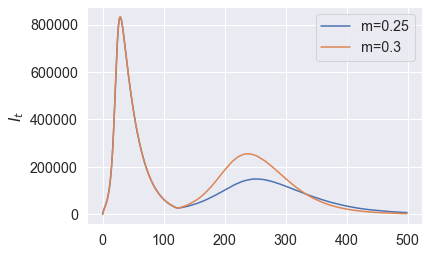

In [738]:
plt.plot(np.mean(trags_I2,axis=1)[:500],label='m=0.25')
plt.plot(np.mean(trags_I22,axis=1)[:500],label='m=0.3')
plt.ylabel('$I_t$')
plt.legend()

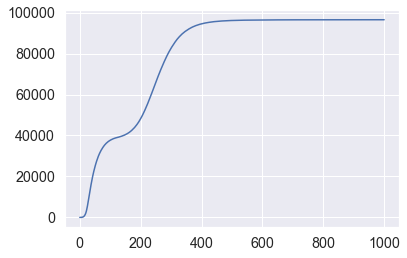

In [179]:
plt.plot(np.mean(deaths2,axis=1))

In [190]:
np.mean(deaths2,axis=1)[(date-lag)]

40719.0

In [728]:
death_long[-1]


51902.0

In [729]:
end = 300

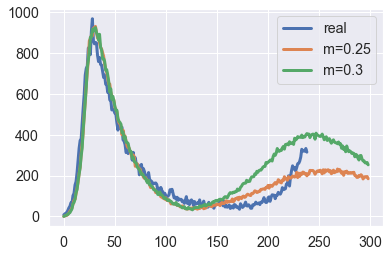

In [742]:
plt.plot(death_short,label='real',linewidth=3)
plt.plot(np.mean(deaths2,axis=1)[1:end]-np.mean(deaths2,axis=1)[:(end-1)],label='m=0.25',linewidth=3)
plt.plot(np.mean(deaths22,axis=1)[1:end]-np.mean(deaths22,axis=1)[:(end-1)],label='m=0.3',linewidth=3)
plt.legend()

In [ ]:
# August 1: 155
# June 30: 125
# Nov 4: 250

In [191]:
date = 155
lag=10

In [192]:
np.mean(trags_I2,axis=1)[(date-lag)]

98208.8

In [193]:
np.mean(trags_A2,axis=1)[(date-lag)]

392423.8

In [194]:
np.mean(deaths2,axis=1)[(date-lag)]

40719.0

In [195]:
np.mean(deaths2,axis=1)[-1]

146093.2

In [196]:
np.max(np.mean(trags_I2,axis=1)[100:])

763957.4

In [197]:
np.max(np.mean(trags_A2,axis=1))

3655909.8

In [187]:
nuts2_region_order = region_order.copy()

In [42]:
for i in range(133):
    nuts2_region_order[i] = nuts2_region_order[i][:3]

In [43]:
death = np.mean(regional_deaths2,axis=0)

In [44]:
normalized_death = death/np.sum(N_mat,axis=0)*100000

In [45]:
data2 = {"$d_r$":sigma_adjust1,"Mortality per 100,000":normalized_death, "NUTS-1":nuts2_region_order,"size":np.ones(133)*50}

In [46]:
data2 = pd.DataFrame(data2)

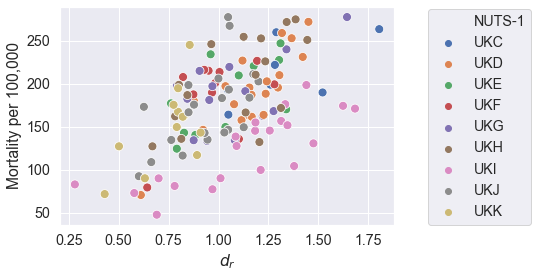

In [47]:
sns.scatterplot(x="$d_r$", y="Mortality per 100,000", hue="NUTS-1",
                     data=data2,s=80)
plt.legend(loc=(1.1,0.))
plt.savefig('results/correlation_fatality_dr_NUTS2.png',bbox_inches="tight")

In [48]:
regional_deaths2.shape

(5, 133)

In [49]:
death = np.mean(regional_deaths2,axis=0)

In [50]:
normalized_death = death/np.sum(N_mat,axis=0)*100000

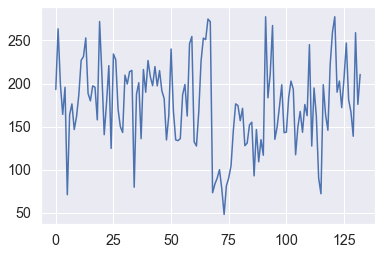

In [51]:
plt.plot(normalized_death)

In [52]:
pre_planned = {"region":np.array(region_order),"death": death}

In [53]:
pre_planned = pd.DataFrame(pre_planned)

In [56]:
!pwd

/Users/renyuanxu/Dropbox/Research_Codes/epidemic_code/Revision_November/pre-planned


In [55]:
pre_planned.to_csv("pre-planned_death.csv")

In [364]:
deaths2[-1,:]

array([96185., 97104., 96228., 96142., 96985., 96502., 96145., 96402.,
       96589., 96680.])

In [198]:
relax = 0.4
relax_day = 120 # 210
nn = 1000

paths = 10

trags3 = np.zeros((nn+1,paths))
deaths3 = np.zeros((nn+1,paths))
trags_I3 = np.zeros((nn+1,paths))
costs3 = np.zeros(paths)



for path in range(paths):
    print(path)
    S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn)

    lenss = np.array(I).shape[0]
    trags3[:,path] = np.sum(england_confirm_cases,axis=1)
    trags_I3[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    deaths3[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    deaths3[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]
    
    
    
    costs3[path] = benchmark_total_contact - total_contact
    

0
1
2
3
4
5
6
7
8
9


In [199]:
12/16

0.75

In [206]:
print(np.mean(deaths[-1,:]),np.mean(deaths2[-1,:]), np.mean(deaths3[-1,:]))

144570.9 146023.9 124443.9


In [211]:
(np.mean(deaths2[-1,:])- np.mean(deaths3[-1,:]))/np.mean(deaths2[-1,:])

0.14778402713528402

In [208]:
print(np.mean(costs),np.mean(costs2), np.mean(costs3))

352902436223.97064 290399691122.61005 338076943312.225


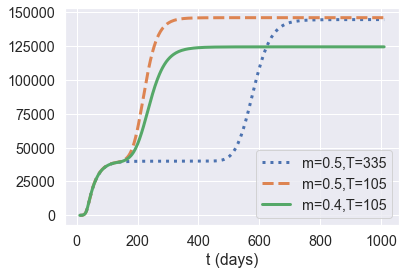

In [209]:
plt.plot(xx,D_mean, label='m=0.5,T=335',linewidth=3,linestyle=':')
plt.plot(xx,D_mean2,  label='m=0.5,T=105',linewidth=3,linestyle='--')
plt.plot(xx,D_mean3, label='m=0.4,T=105',linewidth=3)
plt.legend()
plt.xlabel('t (days)')
plt.savefig("results/openloop_diff_relaxationlevel_Dt_lowratio.png",bbox_inches="tight")

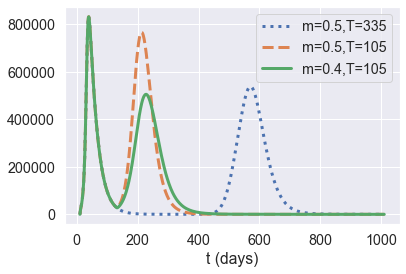

In [210]:
plt.plot(xx,I_mean, label='m=0.5,T=335',linewidth=3,linestyle=':')
plt.plot(xx,I_mean2,  label='m=0.5,T=105',linewidth=3,linestyle='--')
plt.plot(xx,I_mean3, label='m=0.4,T=105',linewidth=3)
plt.legend()
plt.xlabel('t (days)')
plt.savefig("results/openloop_diff_relaxationlevel_It_lowratio.png",bbox_inches="tight")

In [84]:
!pwd

/Users/renyuanxu/Dropbox/Research_Codes/epidemic_code/Revision_November/pre-planned


In [85]:
np.array(I).shape

(1000, 16, 133)

In [61]:
relax = 0.3
relax_day = 120 # 210
nn = 1000

paths = 10

trags4 = np.zeros((nn+1,paths))
deaths4 = np.zeros((nn+1,paths))
trags_I4 = np.zeros((nn+1,paths))
costs4 = np.zeros(paths)
I_all = np.zeros((paths,nn+1,16,133))
D_all= np.zeros((paths,nn+1,16,133))

for path in range(paths):
    print(path)
    S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn)

    lenss = np.array(I).shape[0]
    trags4[:,path] = np.sum(england_confirm_cases,axis=1)
    trags_I4[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    deaths4[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    deaths4[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]
    I_all[path,:lenss,:,:] = np.array(I)
    D_all[path,:lenss,:,:] = np.array(D)
    D_all[path,lenss:,:,:] = np.array(D)[-1,:,:]
    costs4[path] = benchmark_total_contact - total_contact
    

0
1
2
3
4
5
6
7
8
9


In [62]:
D_all2 =np.sum(D_all,axis=2)


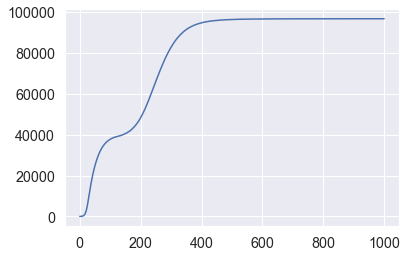

In [63]:
plt.plot(np.mean(np.sum(D_all2,axis=2),axis=0))

In [64]:
np.mean(np.sum(D_all2,axis=2),axis=0)[-1]

96700.8

In [65]:
#region = 48 # birmingham
#region = 89 # oxford
region = 69 # westminster

In [66]:
region_order[region]

'UKI32'

In [67]:
D_all2.shape


(10, 1001, 133)

In [68]:
np.mean(D_all2[:,:,region],axis=0)[-1]

202.0

In [69]:
np.mean(D_all2[:,:,region],axis=0)[107-lag]

122.3

In [70]:
np.mean(np.sum(D_all2[:,:,:],axis=2),axis=0)[-1]

96700.8

In [71]:
np.mean(np.sum(D_all2[:,:,:],axis=2),axis=0)[107-lag]

37471.4

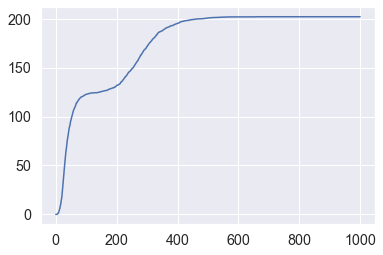

In [72]:
plt.plot(np.mean(D_all2[:,:,region],axis=0))

In [73]:
I_all.shape

(10, 1001, 16, 133)

In [74]:
sns.set(font_scale=1.3)

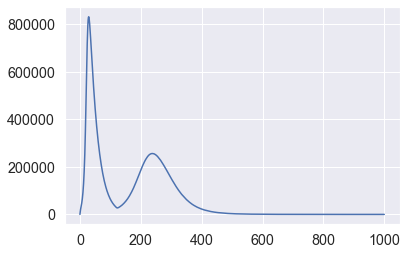

In [75]:
plt.plot(np.mean(np.sum(I_all,axis=(2,3)),axis=0))

In [76]:
region_order[region]

'UKI32'

In [77]:
I_all2 = np.sum(I_all,axis=2)

In [78]:
Ir_mean = np.mean(I_all2[:,:,region],axis=0)

Ir_std = np.std(I_all2[:,:,region],axis=0)

In [79]:
sns.set(font_scale=1.3)

In [80]:
# 40,48,86,4

In [81]:
np.argmax(np.max(np.mean(I_all2,axis=0)[100:,:],axis=0))

30

In [82]:
(np.argmax(np.mean(I_all2,axis=0)[100:,:],axis=0)==247)*np.cumsum(np.ones(133))-1

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.])

In [84]:
xx = np.cumsum(np.ones(1000))-1+lag

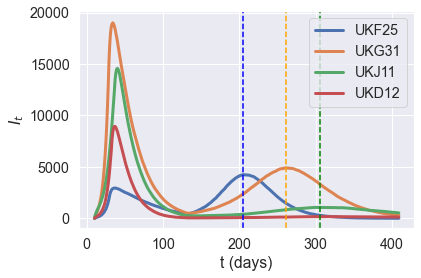

In [86]:
Ir_mean1 = np.mean(I_all2[:,:,40],axis=0)
Ir_std1 = np.std(I_all2[:,:,40],axis=0)

Ir_mean2 = np.mean(I_all2[:,:,48],axis=0)
Ir_std2 = np.std(I_all2[:,:,48],axis=0)

Ir_mean3 = np.mean(I_all2[:,:,86],axis=0)
Ir_std3 = np.std(I_all2[:,:,86],axis=0)

Ir_mean4 = np.mean(I_all2[:,:,4],axis=0)
Ir_std4 = np.std(I_all2[:,:,4],axis=0)
    
plt.plot(xx[:400],Ir_mean1[:400],linewidth=3,label=str(region_order[40]))
plt.fill_between(xx[:400],Ir_mean1[:400] - Ir_std1[:400],Ir_mean1[:400] + Ir_std1[:400],alpha=0.3)

plt.plot(xx[:400],Ir_mean2[:400],linewidth=3,label=str(region_order[48]))
plt.fill_between(xx[:400],Ir_mean2[:400] - Ir_std2[:400],Ir_mean2[:400] + Ir_std2[:400],alpha=0.3)

plt.plot(xx[:400],Ir_mean3[:400],linewidth=3,label=str(region_order[86]))
plt.fill_between(xx[:400],Ir_mean3[:400] - Ir_std3[:400],Ir_mean3[:400] + Ir_std3[:400],alpha=0.3)

plt.plot(xx[:400],Ir_mean4[:400],linewidth=3,label=str(region_order[4]))
plt.fill_between(xx[:400],Ir_mean4[:400] - Ir_std4[:400],Ir_mean4[:400] + Ir_std4[:400],alpha=0.3)
    
peak_time1 = np.argmax(Ir_mean1[100:400]) +100
peak_time2 = np.argmax(Ir_mean2[100:400]) +100
peak_time3 = np.argmax(Ir_mean3[100:400]) +100
peak_time4 = np.argmax(Ir_mean4[100:400]) +100

plt.axvline(x=peak_time1+10,color='blue',linestyle = '--')
plt.axvline(x=peak_time2+10,color='orange',linestyle = '--')
plt.axvline(x=peak_time3+10,color='green',linestyle ='--')
#plt.axvline(x=peak_time4+10,color='red',linestyle ='--')

plt.ylabel(r"$I_t$")
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/openloop_diff_relaxationlevel_heter.png",bbox_inches="tight")

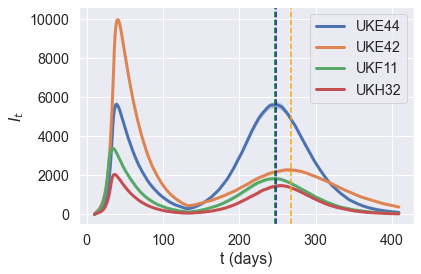

In [716]:
a = 30
b= 29
c = 31
d= 124
Ir_mean1 = np.mean(I_all2[:,:,a],axis=0)
Ir_std1 = np.std(I_all2[:,:,a],axis=0)

Ir_mean2 = np.mean(I_all2[:,:,b],axis=0)
Ir_std2 = np.std(I_all2[:,:,b],axis=0)

Ir_mean3 = np.mean(I_all2[:,:,c],axis=0)
Ir_std3 = np.std(I_all2[:,:,c],axis=0)

Ir_mean4 = np.mean(I_all2[:,:,d],axis=0)
Ir_std4 = np.std(I_all2[:,:,d],axis=0)
    
plt.plot(xx[:400],Ir_mean1[:400],linewidth=3,label=str(region_order[a]))
plt.fill_between(xx[:400],Ir_mean1[:400] - Ir_std1[:400],Ir_mean1[:400] + Ir_std1[:400],alpha=0.3)

plt.plot(xx[:400],Ir_mean2[:400],linewidth=3,label=str(region_order[b]))
plt.fill_between(xx[:400],Ir_mean2[:400] - Ir_std2[:400],Ir_mean2[:400] + Ir_std2[:400],alpha=0.3)

plt.plot(xx[:400],Ir_mean3[:400],linewidth=3,label=str(region_order[c]))
plt.fill_between(xx[:400],Ir_mean3[:400] - Ir_std3[:400],Ir_mean3[:400] + Ir_std3[:400],alpha=0.3)

plt.plot(xx[:400],Ir_mean4[:400],linewidth=3,label=str(region_order[d]))
plt.fill_between(xx[:400],Ir_mean4[:400] - Ir_std4[:400],Ir_mean4[:400] + Ir_std4[:400],alpha=0.3)
    
peak_time1 = np.argmax(Ir_mean1[100:400]) +100
peak_time2 = np.argmax(Ir_mean2[100:400]) +100
peak_time3 = np.argmax(Ir_mean3[100:400]) +100
peak_time4 = np.argmax(Ir_mean4[100:400]) +100

plt.axvline(x=peak_time1+10,color='blue',linestyle = '--')
plt.axvline(x=peak_time2+10,color='orange',linestyle = '--')
plt.axvline(x=peak_time3+10,color='green',linestyle ='--')
#plt.axvline(x=peak_time4+10,color='red',linestyle ='--')

plt.ylabel(r"$I_t$")
plt.xlabel('t (days)')
plt.legend()


# Infected Individuals Ratios

In [152]:
relax = 0.3
relax_day = 120 # 210
nn = 1000

paths = 10

trags5 = np.zeros((nn+1,paths))
deaths5 = np.zeros((nn+1,paths))
trags_I5 = np.zeros((nn+1,paths))
R_all = np.zeros((paths,nn+1,16,133))
R_I_all = np.zeros((paths,nn+1,16,133))
R_A_all = np.zeros((paths,nn+1,16,133))
D_all= np.zeros((paths,nn+1,16,133))
I_all = np.zeros((paths,nn+1,16,133))
A_all= np.zeros((paths,nn+1,16,133))
E_all= np.zeros((paths,nn+1,16,133))
for path in range(paths):
    print(path)
    S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn)
   
    lenss = np.array(I).shape[0]
    trags5[:,path] = np.sum(england_confirm_cases,axis=1)
    trags_I5[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    deaths5[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    deaths5[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]
    R_all[path,:lenss,:,:] = np.array(R)
    R_all[path,lenss:,:,:] = np.array(R)[-1,:,:]
    
    R_A_all[path,:lenss,:,:] = np.array(R_A)
    R_A_all[path,lenss:,:,:] = np.array(R_A)[-1,:,:]
    
    R_I_all[path,:lenss,:,:] = np.array(R_I)
    R_I_all[path,lenss:,:,:] = np.array(R_I)[-1,:,:]
    
    D_all[path,:lenss,:,:] = np.array(D)
    D_all[path,lenss:,:,:] = np.array(D)[-1,:,:]
    I_all[path,:lenss,:,:] = np.array(I)
    E_all[path,:lenss,:,:] = np.array(E)
    A_all[path,:lenss,:,:] = np.array(A)
    
    

0
1
2
3
4
5
6
7
8
9


In [153]:
R_all.shape

(10, 1001, 16, 133)

In [154]:
lag = 10

In [155]:
# June 31 125 (delta=0)
# Nov 4  250 (delta = 127)

In [156]:
delta= 30

In [157]:
R_all2 = R_all[:,125+delta-lag,:,:]
R_A_all2 = R_A_all[:,125+delta-lag,:,:]
R_I_all2 = R_I_all[:,125+delta-lag,:,:]

D_all2 = D_all[:,125+delta-lag,:,:]
I_all2 = I_all[:,125+delta-lag,:,:]
A_all2 = A_all[:,125+delta-lag,:,:]
E_all2 = E_all[:,125+delta-lag,:,:]

In [158]:
R_all2.shape

(10, 16, 133)

In [159]:
R_region = np.mean(np.sum(R_all2,axis=1),axis=0)

R_A_region = np.mean(np.sum(R_A_all2,axis=1),axis=0)
R_I_region = np.mean(np.sum(R_I_all2,axis=1),axis=0)

D_region = np.mean(np.sum(D_all2,axis=1),axis=0)

In [160]:
I_region = np.mean(np.sum(I_all2,axis=1),axis=0)
A_region = np.mean(np.sum(A_all2,axis=1),axis=0)
E_region = np.mean(np.sum(E_all2,axis=1),axis=0)

In [161]:
np.sum(N_mat)

56171302.0

In [162]:
print(np.sum(R_A_region),np.sum(R_I_region),np.sum(D_region))

14787455.7 3412885.2 40124.799999999996


In [163]:
print(np.sum(R_A_region)/np.sum(N_mat),np.sum(R_I_region)/np.sum(N_mat),np.sum(D_region)/np.sum(N_mat))

0.2632564169511328 0.06075852042738835 0.000714329178269715


In [175]:
np.sum(N_mat,axis=1)/np.sum(N_mat)

array([0.05905703, 0.06293148, 0.0590679 , 0.0550731 , 0.06228191,
       0.0679437 , 0.06775697, 0.06645164, 0.06063449, 0.06697173,
       0.06968242, 0.06454171, 0.05486307, 0.05006873, 0.04902267,
       0.08365147])

In [164]:
(np.sum(R_region))/np.sum(N_mat)

0.3240149373785211

In [165]:
(np.sum(R_region)+np.sum(D_region))# OLD

18240465.7

In [166]:
(np.sum(R_region)+np.sum(D_region)+np.sum(I_region)+np.sum(A_region))/np.sum(N_mat)

0.328936078426667

In [171]:
(np.sum(R_region)+np.sum(D_region)+np.sum(I_region)+np.sum(A_region))/np.sum(N_mat)

0.328936078426667

In [172]:
np.sum(R_region)+np.sum(D_region)+np.sum(I_region)+np.sum(A_region)

18476767.799999997

In [168]:
np.sum(I_region)

47114.2

In [169]:
np.sum(A_region)

189187.90000000002

In [170]:
np.sum(E_region)

151819.80000000002

In [645]:
np.sum(R_region)

22445269.6

In [646]:
np.sum(D_region)

50930.5

In [603]:
!pwd

/Users/renyuanxu/Dropbox/Research_Codes/epidemic_code/Revision_November/pre-planned


In [604]:
uninfected = 1 - (R_region+D_region)/np.sum(N_mat,axis=0)

In [605]:
data =  {"region":np.array(region_order),"uninfected_ratio":uninfected}

In [606]:
data = pd.DataFrame(data)

In [607]:
data.to_csv('results/social_distancing_uninfected_ratio_august1_m25.csv',index=False)

In [608]:
I_all.shape

(10, 1001, 16, 133)

# Map

In [647]:
relax = 0.25
relax_day = 120 # 210
nn = 1000

paths = 20

trags5 = np.zeros((nn+1,paths))
deaths5 = np.zeros((nn+1,paths))
trags_I5 = np.zeros((nn+1,paths))
R_all = np.zeros((paths,nn+1,16,133))
R_I_all = np.zeros((paths,nn+1,16,133))
R_A_all = np.zeros((paths,nn+1,16,133))
D_all= np.zeros((paths,nn+1,16,133))
I_all = np.zeros((paths,nn+1,16,133))
A_all= np.zeros((paths,nn+1,16,133))
E_all= np.zeros((paths,nn+1,16,133))
for path in range(paths):
    print(path)
    S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn)
   
    lenss = np.array(I).shape[0]
    trags5[:,path] = np.sum(england_confirm_cases,axis=1)
    trags_I5[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    deaths5[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    deaths5[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]
    R_all[path,:lenss,:,:] = np.array(R)
    R_all[path,lenss:,:,:] = np.array(R)[-1,:,:]
    
    R_A_all[path,:lenss,:,:] = np.array(R_A)
    R_A_all[path,lenss:,:,:] = np.array(R_A)[-1,:,:]
    
    R_I_all[path,:lenss,:,:] = np.array(R_I)
    R_I_all[path,lenss:,:,:] = np.array(R_I)[-1,:,:]
    
    D_all[path,:lenss,:,:] = np.array(D)
    D_all[path,lenss:,:,:] = np.array(D)[-1,:,:]
    I_all[path,:lenss,:,:] = np.array(I)
    E_all[path,:lenss,:,:] = np.array(E)
    A_all[path,:lenss,:,:] = np.array(A)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [648]:
total_death_rgs = np.zeros(133)

In [649]:
for i in range(133):
    total_death_rgs[i] = np.sum(np.mean(D_all[:,:,:,i],axis=0),axis=1)[-1]
   

In [650]:
data_fatality = pd.DataFrame(columns=['region','death_socialdistance'])

data_fatality['region'] = d_table['region']

data_fatality['death_socialdistance'] = total_death_rgs


data_fatality.to_csv('death_socialdistance_16groups_m25.csv',index=False)

In [654]:
np.mean(np.sum(D_all,axis=(2,3)),axis=0)[250-10]

50948.9